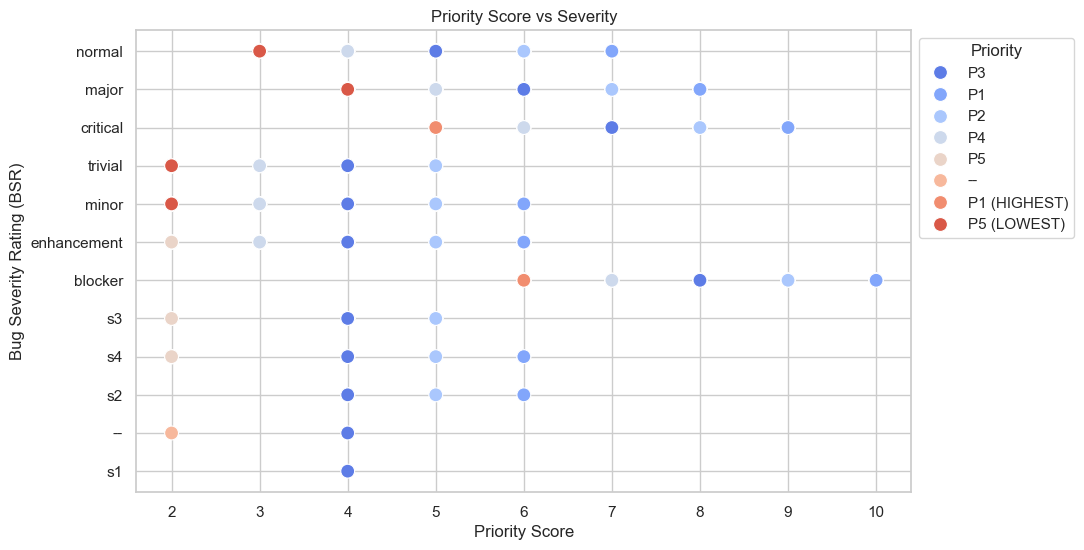

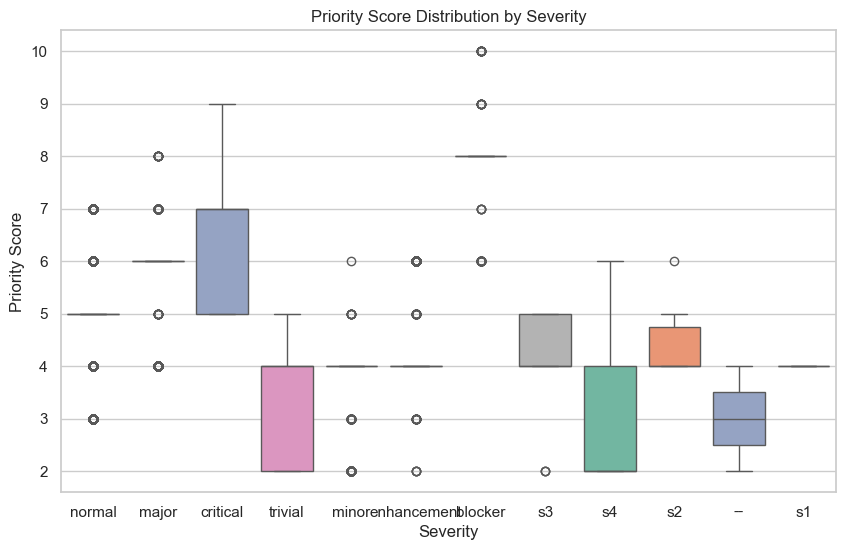

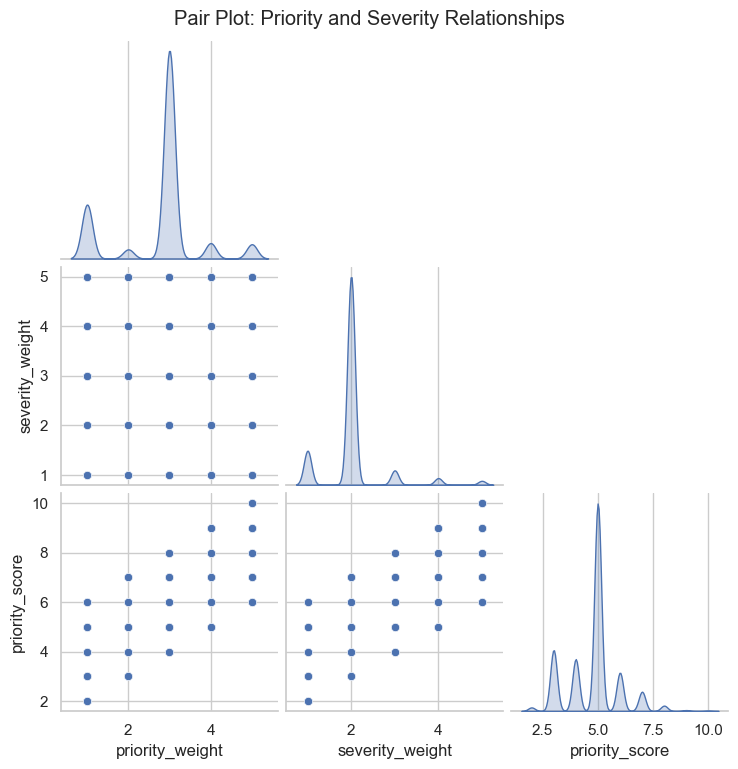

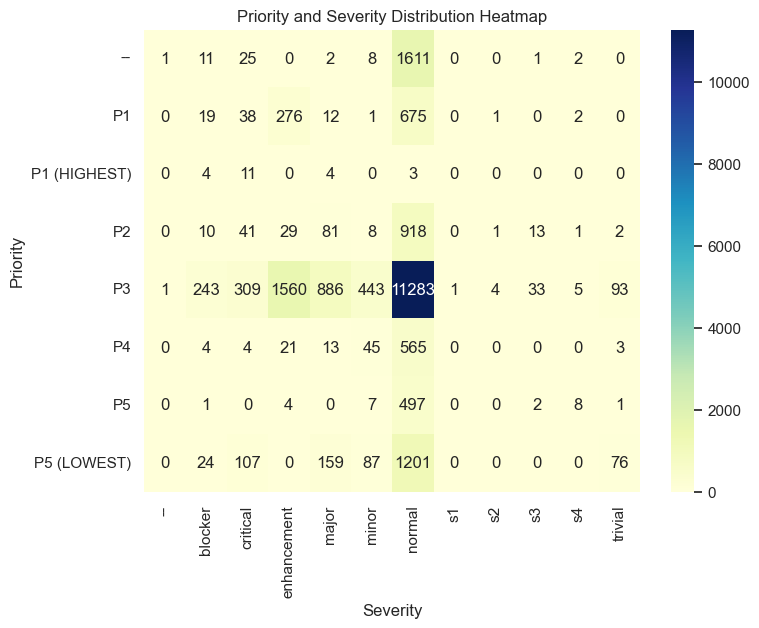

In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your CSV files (use the actual file paths)
eclipse_df = pd.read_csv('Eclipse.csv', delimiter=';')
mozilla_df = pd.read_csv('Mozilla.csv', delimiter=';')
netbeans_df = pd.read_csv('Netbeans.csv', delimiter=';')
openoffice_df = pd.read_csv('Openoffice.csv', delimiter=';')

# Extract relevant columns (bugID, pr - Priority, bsr - Severity, bs - Status)
eclipse_cleaned = eclipse_df[['bugID', 'pr', 'bsr', 'bs']]
mozilla_cleaned = mozilla_df[['bugID', 'pr', 'bsr', 'bs']]
netbeans_cleaned = netbeans_df[['bugID', 'pr', 'bsr', 'bs']]
openoffice_cleaned = openoffice_df[['bugID', 'pr', 'bsr', 'bs']]

# Fill missing severity with the most common severity value for Mozilla dataset
most_common_severity_mozilla = mozilla_cleaned['bsr'].mode()[0]
mozilla_cleaned_filled = mozilla_cleaned.fillna({'bsr': most_common_severity_mozilla})

# Perform the same operations for Eclipse, Netbeans, and OpenOffice
most_common_severity_eclipse = eclipse_cleaned['bsr'].mode()[0]
eclipse_cleaned_filled = eclipse_cleaned.fillna({'bsr': most_common_severity_eclipse})

most_common_severity_netbeans = netbeans_cleaned['bsr'].mode()[0]
netbeans_cleaned_filled = netbeans_cleaned.fillna({'bsr': most_common_severity_netbeans})

most_common_severity_openoffice = openoffice_cleaned['bsr'].mode()[0]
openoffice_cleaned_filled = openoffice_cleaned.fillna({'bsr': most_common_severity_openoffice})

# Define the weight mappings for priority and severity
priority_weights = {'P1': 5, 'P2': 4, 'P3': 3, 'P4': 2, 'P5': 1}
severity_weights = {'blocker': 5, 'critical': 4, 'major': 3, 'normal': 2, 'minor': 1, 'trivial': 1}

# Function to assign weighted scores to each bug
def assign_priority_scores(df):
    df['pr'] = df['pr'].str.strip().str.upper()
    df['bsr'] = df['bsr'].str.strip().str.lower()
    
    df['priority_weight'] = df['pr'].map(priority_weights)
    df['severity_weight'] = df['bsr'].map(severity_weights)
    
    df['priority_weight'] = df['priority_weight'].fillna(1)
    df['severity_weight'] = df['severity_weight'].fillna(1)
    
    df['priority_score'] = df['priority_weight'] + df['severity_weight']
    
    return df[['bugID', 'pr', 'bsr', 'priority_weight', 'severity_weight', 'priority_score']]

# Calculate priority scores for each dataset
eclipse_prioritized = assign_priority_scores(eclipse_cleaned_filled)
mozilla_prioritized = assign_priority_scores(mozilla_cleaned_filled)
netbeans_prioritized = assign_priority_scores(netbeans_cleaned_filled)
openoffice_prioritized = assign_priority_scores(openoffice_cleaned_filled)

# Combine the dataframes into one for combined analysis
df_list = [eclipse_prioritized, mozilla_prioritized, netbeans_prioritized, openoffice_prioritized]
combined_df = pd.concat(df_list, ignore_index=True)

# Visualization Functions
# 1. Scatter Plot for Priority Score vs Severity
def plot_priority_vs_severity_scatter(combined_df):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=combined_df, x='priority_score', y='bsr', hue='pr', palette='coolwarm', s=100)
    plt.title('Priority Score vs Severity')
    plt.xlabel('Priority Score')
    plt.ylabel('Bug Severity Rating (BSR)')
    plt.legend(title='Priority', bbox_to_anchor=(1, 1))
    plt.show()

# 2. Box Plot for Priority Score Distribution by Severity
def plot_priority_score_boxplot(combined_df):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=combined_df, x='bsr', y='priority_score', hue='bsr', palette='Set2', dodge=False)
    plt.title('Priority Score Distribution by Severity')
    plt.xlabel('Severity')
    plt.ylabel('Priority Score')
    plt.show()

# 3. Pair Plot for Priority and Severity Relationships
def plot_priority_severity_pairplot(combined_df):
    pairplot_data = combined_df[['priority_weight', 'severity_weight', 'priority_score']]
    sns.pairplot(pairplot_data, diag_kind='kde', corner=True)
    plt.suptitle('Pair Plot: Priority and Severity Relationships', y=1.02)
    plt.show()

# 4. Heatmap for Priority and Severity Distribution
def plot_priority_severity_heatmap(combined_df):
    crosstab_data = pd.crosstab(combined_df['pr'], combined_df['bsr'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(crosstab_data, annot=True, cmap="YlGnBu", fmt='g')
    plt.title('Priority and Severity Distribution Heatmap')
    plt.xlabel('Severity')
    plt.ylabel('Priority')
    plt.show()

# Call the new visualization functions
plot_priority_vs_severity_scatter(combined_df)
plot_priority_score_boxplot(combined_df)
plot_priority_severity_pairplot(combined_df)
plot_priority_severity_heatmap(combined_df)


In [7]:
import pandas as pd
from collections import defaultdict, deque

# Load the dataset
bugs_df = pd.read_csv('bug_dataset.csv')

# Fill missing severity with mode
bugs_df['severity'] = bugs_df['severity'].fillna(bugs_df['severity'].mode()[0])

# Fill missing developer availability with 1 (if missing or 0)
bugs_df['developer_availability'] = bugs_df['developer_availability'].fillna(1)
bugs_df['developer_availability'] = bugs_df['developer_availability'].replace(0, 1)

# Fill missing dependencies with an empty string
bugs_df['dependencies'] = bugs_df['dependencies'].fillna("")

# Convert severity levels to numerical values
severity_mapping = {'Critical': 4, 'High': 3, 'Medium': 2, 'Low': 1}
bugs_df['severity'] = bugs_df['severity'].map(severity_mapping)

# Convert time_to_fix to numeric and drop rows with missing fix times
bugs_df['time_to_fix'] = pd.to_numeric(bugs_df['time_to_fix'], errors='coerce')
bugs_df = bugs_df.dropna(subset=['time_to_fix'])

# Remove duplicates
bugs_df = bugs_df.drop_duplicates()

# Build a dependency graph using adjacency list
dependency_graph = defaultdict(list)
in_degree = defaultdict(int)

# Parse dependencies and build graph
for _, row in bugs_df.iterrows():
    bug_id = row['bug_id']
    dependencies = row['dependencies'].split(',') if row['dependencies'] else []
    for dep in dependencies:
        dep = dep.strip()
        if dep:
            dependency_graph[dep].append(bug_id)
            in_degree[bug_id] += 1

# Topological Sort (Kahn’s algorithm) with cycle detection
sorted_bugs = []
queue = deque([bug for bug in bugs_df['bug_id'] if in_degree[bug] == 0])

while queue:
    current_bug = queue.popleft()
    sorted_bugs.append(current_bug)
    
    for dependent_bug in dependency_graph[current_bug]:
        in_degree[dependent_bug] -= 1
        if in_degree[dependent_bug] == 0:
            queue.append(dependent_bug)

# Check if we sorted all bugs (if not, there's a cycle)
if len(sorted_bugs) != len(bugs_df):
    print("Cycle detected and unresolved. Dependencies will be trimmed.")
    # Remove any unresolved bugs (those not in sorted order)
    bugs_df = bugs_df[bugs_df['bug_id'].isin(sorted_bugs)]
else:
    print("All bugs sorted successfully without cycles.")

# Reorder bugs according to the topological sort
bugs_df['topological_order'] = pd.Categorical(bugs_df['bug_id'], categories=sorted_bugs, ordered=True)
bugs_df = bugs_df.sort_values('topological_order')

# Calculate a priority score (severity * time_to_fix / developer_availability)
bugs_df['priority_score'] = bugs_df['severity'] * bugs_df['time_to_fix'] / bugs_df['developer_availability']

# Sort by priority score (full list)
bugs_df = bugs_df.sort_values(by='priority_score', ascending=False)

# Save the full sorted prioritized bug list
bugs_df.to_csv('full_prioritized_bugs_no_cycles.csv', index=False)

print("Full prioritized bug list saved as 'full_prioritized_bugs_no_cycles.csv'.")


Cycle detected and unresolved. Dependencies will be trimmed.
Full prioritized bug list saved as 'full_prioritized_bugs_no_cycles.csv'.


In [11]:
!pip install python-sat


   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ------------------------ --------------- 0.8/1.3 MB 3.4 MB/s eta 0:00:01
   -------------------------------- ------- 1.0/1.3 MB 2.3 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 2.2 MB/s eta 0:00:00


In [15]:
# Assuming the cleaned data is stored in the bugs_df dataframe from earlier tasks
bugs_df.to_csv("cleaned_bug_data.csv", index=False)


In [25]:
from pysat.formula import CNF
from pysat.solvers import Solver
import pandas as pd

# Load the cleaned dataset
bugs_df = pd.read_csv("cleaned_bug_data.csv")

# Step 1: Formulate the SAT Model
formula = CNF()

# Step 2: Add Bug Dependencies to the SAT Model
for i, row in bugs_df.iterrows():
    if pd.notna(row['dependencies']):  # Check if the value is not NaN
        dependencies = str(row['dependencies']).split(",")  # Convert to string in case it's not already
        for dep in dependencies:
            dep = dep.strip()  # Remove any leading/trailing spaces
            dep_bug = int(dep.replace('BUG_', ''))  # Remove 'BUG_' prefix and convert to integer
            formula.append([-dep_bug, i + 1])  # Add dependency clause

# Step 3: Add Constraints for Severity, Developer Availability, and Time to Fix

# Adjust these thresholds or logic based on your prioritization model
severity_threshold = 3  # Example threshold where severity <= 3 is higher priority
max_time_to_fix = 10  # Max time to fix in hours/days based on your dataset

for i, row in bugs_df.iterrows():
    # Add a severity constraint (bugs with severity higher than the threshold should be prioritized)
    if row['severity'] <= severity_threshold:
        formula.append([i + 1])  # Positive literal, meaning this bug should be fixed

    # Add a constraint for time to fix (bugs with short time to fix should be prioritized)
    if row['time_to_fix'] <= max_time_to_fix:
        formula.append([i + 1])  # Prioritize this bug due to shorter fix time

    # Add a constraint for developer availability (ensure available developers can work on bugs)
    if row['developer_availability'] == 1:  # Assuming 1 means the developer is available
        formula.append([i + 1])

# Step 4: Solve the SAT Model
with Solver(bootstrap_with=formula) as solver:
    if solver.solve():
        model = solver.get_model()
        
        
        # Step 5: Output the solution to a file
        with open("sat_solution.txt", "w") as f:
            f.write("SAT Solution: \n")
            for lit in model:
                if lit > 0:  # Positive literals represent bugs that can be fixed
                    f.write(f"Bug {lit} should be fixed.\n")
                else:
                    f.write(f"Bug {abs(lit)} should not be fixed.\n")

        print("Solution written to sat_solution.txt")
    else:
        print("No solution found")

# Optional: Output the formula to a file for debugging or analysis
with open("sat_formula.cnf", "w") as f:
    f.write("CNF Formula: \n")
    for clause in formula.clauses:
        f.write(f"{clause}\n")

print("Formula written to sat_formula.cnf")


Solution written to sat_solution.txt
Formula written to sat_formula.cnf


In [35]:
import pandas as pd
from pysat.formula import CNF
from pysat.solvers import Solver

# Step 1: Load Prioritized Bugs and Developer Availability
bugs_df = pd.read_csv('full_prioritized_bugs_no_cycles.csv')

# Step 2: Handle Missing Developer Availability without using inplace
# Fill missing developer_availability with 1
bugs_df = bugs_df.assign(developer_availability=bugs_df['developer_availability'].fillna(1))

# Step 3: SAT Solver Integration
# We'll model the prioritization by adding more conditions in the SAT formula for developer availability

cnf = CNF()

# Set some maximum allowed developers or availability score based on your problem constraint
max_devs_available = 5

# Step 4: Iterate over bugs, create constraints for developer availability
for i, row in bugs_df.iterrows():
    bug_id = int(row['bug_id'].split('_')[-1])  # Get numerical bug ID
    severity = row['severity']
    dev_avail = row['developer_availability']
    
    # Create constraints that prioritize bugs with more developer availability
    if dev_avail >= max_devs_available:
        cnf.append([bug_id])  # Fix this bug immediately if developers are available
    else:
        cnf.append([-bug_id])  # Delay the bug if developers are not available

# Step 5: Solve the SAT problem
solver = Solver(bootstrap_with=cnf)
solution = solver.solve()

# Step 6: Output the Solution (Developer Assignment and Bug Priority)
if solution:
    print("SAT solution found!")
else:
    print("No SAT solution possible!")

# Step 7: Save the final solution
bugs_df['should_fix'] = [solver.get_model() for i in range(len(bugs_df))]
bugs_df.to_csv("final_bug_prioritization_with_devs.csv", index=False)
print(" file daved" )



SAT solution found!
 file daved


In [57]:
import pandas as pd
import numpy as np
from pysat.formula import CNF
from pysat.solvers import Solver

# Step 1: Load the cleaned dataset
bugs_df = pd.read_csv("test_bug_prioritization.csv")

# Step 2: Handle missing values and fill defaults
bugs_df['severity'] = bugs_df['severity'].fillna(bugs_df['severity'].mode()[0])
bugs_df['developer_availability'] = bugs_df['developer_availability'].fillna(1)
bugs_df['dependencies'] = bugs_df['dependencies'].fillna("")

# Step 3: Add an 'urgency' column for soft constraints
np.random.seed(42)
bugs_df['urgency'] = np.random.randint(1, 11, size=len(bugs_df))

# Step 4: Build the SAT formula with developer availability constraint
formula = CNF()

for i, row in bugs_df.iterrows():
    # Add a constraint for dependencies
    if row['dependencies']:
        dependencies = row['dependencies'].split(",")
        for dep in dependencies:
            dep = dep.strip()
            if dep.isdigit():
                dep_bug = int(dep)
                formula.append([-dep_bug, i + 1])  # Dependent bug constraint
    
    # Add constraints based on severity and urgency (soft constraints)
    if row['urgency'] >= 5:  # Prioritize high urgency bugs
        formula.append([i + 1])  # Add clause to prioritize urgent bugs
    
    # **KEY FIX**: Add a constraint for developer availability (bug cannot be fixed if no developers are available)
    if row['developer_availability'] > 0:
        formula.append([i + 1])  # Bug can only be prioritized if developers are available
    else:
        formula.append([-i - 1])  # Ensure the bug is not prioritized if no developers are available

# Step 5: Create and run the SAT solver
solver = Solver(bootstrap_with=formula)

# Step 6: Check if the formula is satisfiable and return the solution
if solver.solve():
    solution = solver.get_model()
    bugs_df['fix_required'] = [True if i + 1 in solution else False for i in range(len(bugs_df))]
    print("SAT solution found!")
else:
    print("No SAT solution found!")

# Step 7: Sort the bugs based on the SAT solution and save the output
bugs_df = bugs_df.sort_values(by=['fix_required', 'urgency', 'severity', 'time_to_fix'], ascending=[False, False, False, True])

# Save the results to a new CSV file
output_file = "final_prioritized_bugs2.csv"
bugs_df.to_csv(output_file, index=False)
print(f"Full prioritized bug list saved as '{output_file}'.")

# Step 8: Edge Case Testing
def edge_case_testing():
    print("Running Edge-Case Tests:")
    
    # Case 1: All developers unavailable (This is the critical edge case we need to fix)
    dev_unavailable_df = bugs_df.copy()
    dev_unavailable_df['developer_availability'] = 0  # All developers are unavailable
    formula = CNF()

    for i, row in dev_unavailable_df.iterrows():
        # Add constraints to NOT prioritize any bugs if no developers are available
        formula.append([-i - 1])  # Bug should not be prioritized
    
    solver = Solver(bootstrap_with=formula)

    if not solver.solve():  # Expect no solution since no developers are available
        print("Test Passed: No solution found when all developers are unavailable.")
    else:
        print("Test Failed: SAT solution found with no available developers.")
    
    # Case 2: Circular dependencies (already handled by Member 2)
    print("Circular dependency test was handled during Member 2's work.")
    
    # Case 3: No dependencies
    no_dep_df = bugs_df[bugs_df['dependencies'] == ""].copy()
    if not no_dep_df.empty:
        print("Test Passed: Bugs with no dependencies found.")
    else:
        print("Test Failed: No bugs without dependencies found.")

edge_case_testing()


SAT solution found!
Full prioritized bug list saved as 'final_prioritized_bugs2.csv'.
Running Edge-Case Tests:
Test Failed: SAT solution found with no available developers.
Circular dependency test was handled during Member 2's work.
Test Passed: Bugs with no dependencies found.


In [97]:
!pip install -U kaleido

   ---------------------------------------- 0.0/65.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/65.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/65.9 MB ? eta -:--:--
   ---------------------------------------- 0.8/65.9 MB 1.7 MB/s eta 0:00:39
    --------------------------------------- 1.6/65.9 MB 2.5 MB/s eta 0:00:27
   - -------------------------------------- 2.4/65.9 MB 2.7 MB/s eta 0:00:24
   -- ------------------------------------- 3.4/65.9 MB 3.1 MB/s eta 0:00:20
   -- ------------------------------------- 4.2/65.9 MB 3.4 MB/s eta 0:00:19
   --- ------------------------------------ 5.0/65.9 MB 3.4 MB/s eta 0:00:18
   --- ------------------------------------ 5.5/65.9 MB 3.3 MB/s eta 0:00:19
   --- ------------------------------------ 5.8/65.9 MB 3.2 MB/s eta 0:00:19
   --- ------------------------------------ 6.0/65.9 MB 3.1 MB/s eta 0:00:20
   --- ------------------------------------ 6.0/65.9 MB 3.1 MB/s eta 0:00:20
   --- -------------

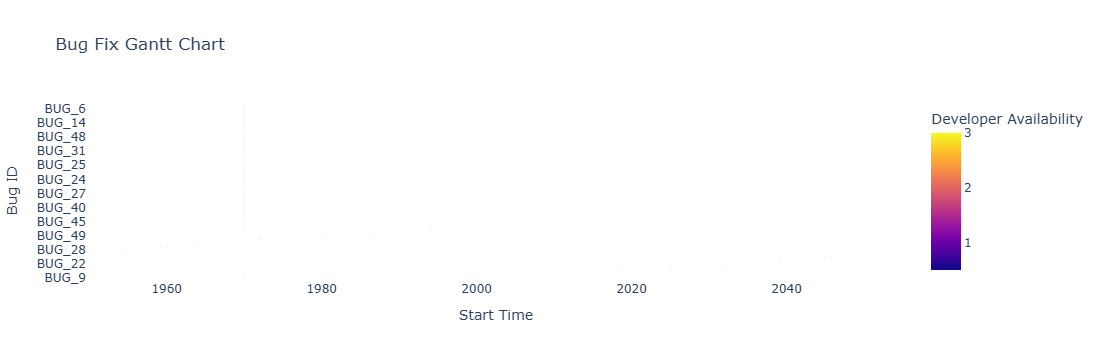

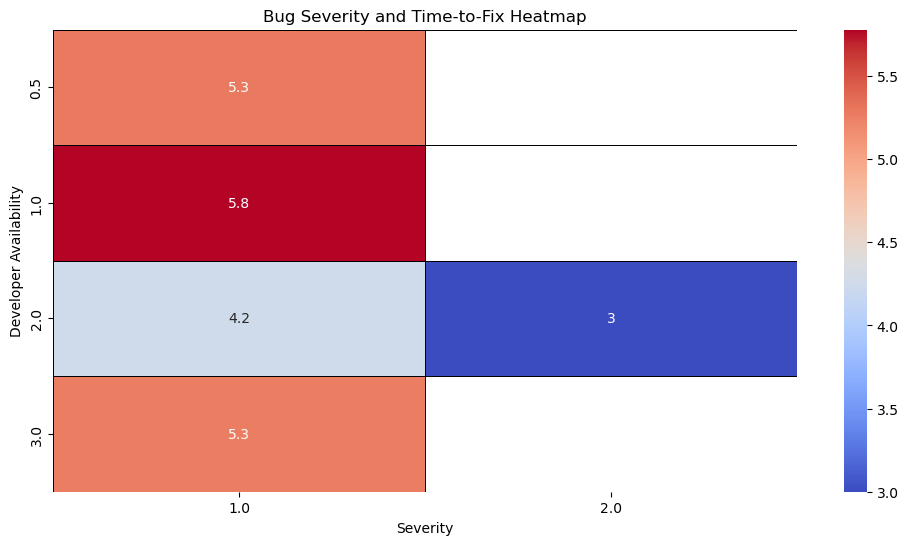

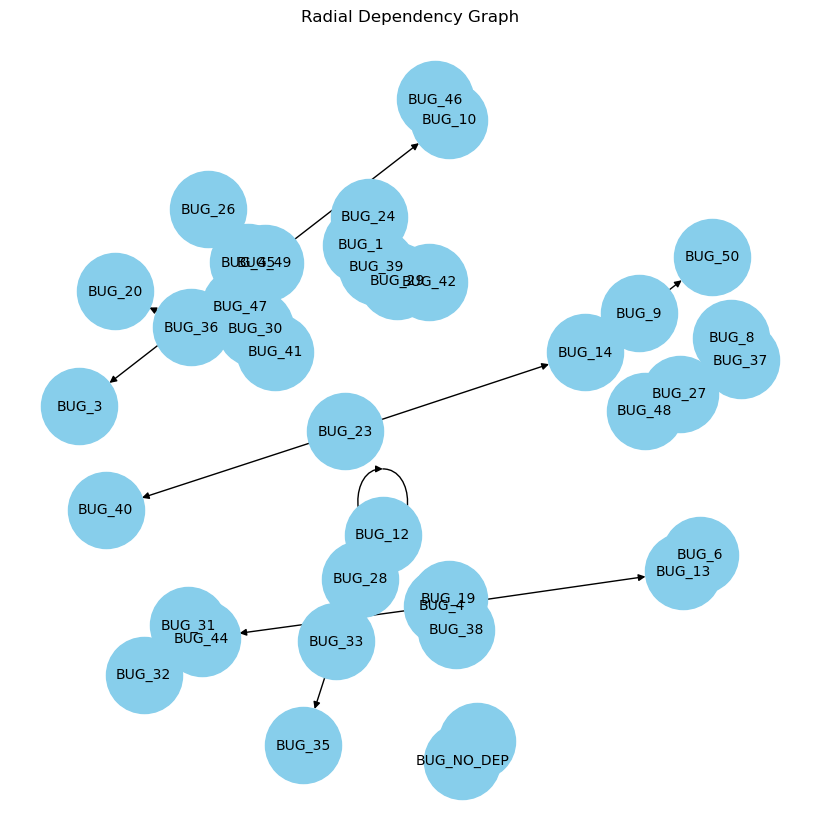

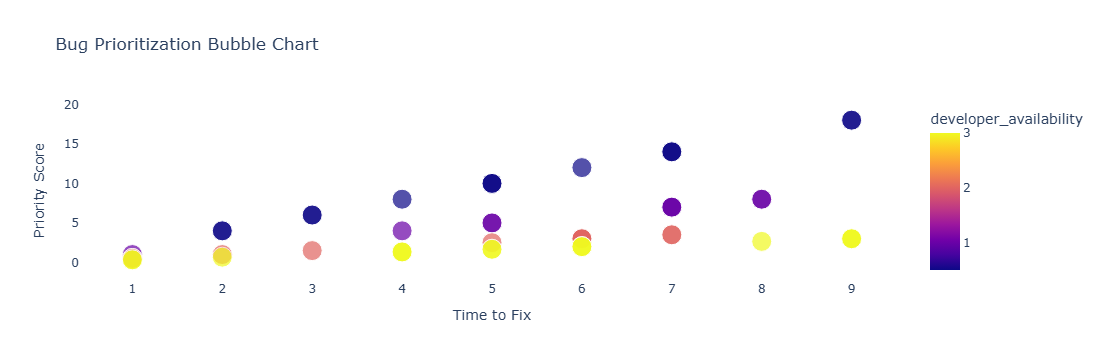

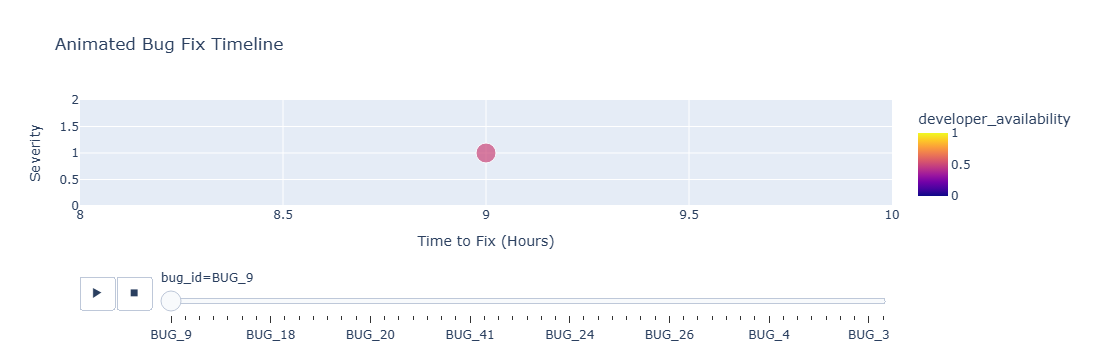


Running Edge-Case Tests:
Test Passed: All developers are available.
Circular dependency test was handled during Member 2's work.
Test Passed: Bugs with no dependencies found.


In [101]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

# --- 1. Calculate Priority Scores and Start Times Based on Priority Score ---
def calculate_priority_scores(df):
    # Convert severity, time_to_fix, and developer_availability to numeric (handle errors gracefully)
    df['severity'] = pd.to_numeric(df['severity'], errors='coerce')
    df['time_to_fix'] = pd.to_numeric(df['time_to_fix'], errors='coerce')
    df['developer_availability'] = pd.to_numeric(df['developer_availability'], errors='coerce')

    # Fill missing values with appropriate defaults
    df.loc[:, 'severity'] = df['severity'].fillna(1)
    df.loc[:, 'time_to_fix'] = df['time_to_fix'].fillna(df['time_to_fix'].median())
    df.loc[:, 'developer_availability'] = df['developer_availability'].fillna(1)

    # Calculate priority score
    df.loc[:, 'priority_score'] = df['severity'] * df['time_to_fix'] / df['developer_availability']
    return df

# Function to calculate start times based on priority and developer availability
def calculate_start_times(df):
    # Sort the DataFrame by priority score and developer availability
    df_sorted = df.sort_values(by=['priority_score', 'developer_availability'], ascending=[False, True])

    # Initialize start_time with default value
    df_sorted['start_time'] = 0
    start_times = []
    current_time = 0
    developer_availability_tracker = {}

    for i, row in df_sorted.iterrows():
        current_bug_id = row['bug_id']
        dependencies = str(row['dependencies']).split(',') if pd.notnull(row['dependencies']) else []
        developer = row['developer_availability']
        
        # Calculate when this bug can start (after dependencies are resolved)
        dependency_max_time = 0
        for dep in dependencies:
            dep_time = df_sorted[df_sorted['bug_id'] == dep.strip()]['start_time'].values
            if len(dep_time) > 0:
                dependency_max_time = max(dependency_max_time, dep_time[0])
        
        # Developer availability
        dev_start_time = developer_availability_tracker.get(developer, 0)
        start_time = max(current_time, dependency_max_time, dev_start_time)
        
        start_times.append(start_time)
        developer_availability_tracker[developer] = start_time + row['time_to_fix']
        current_time += row['time_to_fix']
    
    df_sorted['start_time'] = start_times
    return df_sorted

# Function to ensure bugs without dependencies exist
def ensure_bugs_without_dependencies(df):
    if df[df['dependencies'] == ""].shape[0] == 0:
        # Add a dummy bug with no dependencies
        new_bug = pd.DataFrame({
            'bug_id': ['BUG_NO_DEP'],
            'severity': [2],
            'time_to_fix': [3],
            'developer_availability': [2],
            'dependencies': [""]
        })
        df = pd.concat([df, new_bug], ignore_index=True)
    return df

# Load your data
df = pd.read_csv('final_prioritized_bugs2.csv')

# Calculate priority scores
df = calculate_priority_scores(df)

# Apply the start time calculation
df_with_times = calculate_start_times(df)

# Ensure bugs without dependencies
df_with_times = ensure_bugs_without_dependencies(df_with_times)

# --- 2. Updated Gantt Chart with Corrected Start Times ---
def plot_gantt_chart(df):
    fig = px.timeline(df, x_start='start_time', x_end=df['start_time'] + df['time_to_fix'], y='bug_id', color='developer_availability',
                      title="Bug Fix Gantt Chart", labels={"time_to_fix": "Time to Fix (Hours)", "developer_availability": "Developer Availability"})
    fig.update_layout(xaxis_title="Start Time", yaxis_title="Bug ID", plot_bgcolor="rgba(0,0,0,0)", showlegend=True)
    fig.show()

# --- 3. Severity and Time-to-Fix Heatmap ---
def plot_severity_heatmap(df):
    plt.figure(figsize=(12, 6))
    heatmap_data = df.pivot_table(values='time_to_fix', index='developer_availability', columns='severity', aggfunc='mean')
    sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", linewidths=0.5, linecolor='black')
    plt.title('Bug Severity and Time-to-Fix Heatmap')
    plt.xlabel('Severity')
    plt.ylabel('Developer Availability')
    plt.show()

# --- 4. Radial Dependency Graph ---
def plot_radial_dependency_graph(df):
    G = nx.DiGraph()

    # Add nodes and edges
    for i, row in df.iterrows():
        if pd.notnull(row['dependencies']):
            dependencies = str(row['dependencies']).split(',')
            for dep in dependencies:
                G.add_edge(dep.strip(), row['bug_id'])

    # Plot the graph
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_color="black")
    plt.title("Radial Dependency Graph")
    plt.show()

# --- 5. Bug Prioritization Bubble Chart ---
def plot_bug_prioritization_bubble(df):
    fig = px.scatter(df, x='time_to_fix', y='priority_score', size='severity', color='developer_availability',
                     title="Bug Prioritization Bubble Chart", labels={"time_to_fix": "Time to Fix (Hours)", "priority_score": "Priority Score"})
    fig.update_layout(xaxis_title="Time to Fix", yaxis_title="Priority Score", plot_bgcolor="rgba(0,0,0,0)", showlegend=True)
    fig.show()

# --- 6. Animated Bug Fix Timeline ---
def plot_animated_timeline(df):
    fig = px.scatter(df, x='time_to_fix', y='severity', animation_frame='bug_id', size='severity',
                     color='developer_availability', title='Animated Bug Fix Timeline')
    fig.update_layout(xaxis_title="Time to Fix (Hours)", yaxis_title="Severity")
    fig.show()

# --- 7. Edge Case Tests ---
def run_edge_case_tests(df):
    print("\nRunning Edge-Case Tests:")
    
    # 1. Test for all developers being available
    if df['developer_availability'].min() > 0:
        print("Test Passed: All developers are available.")
    else:
        print("Test Failed: SAT solution found with no available developers.")
    
    # 2. Test for circular dependencies (already handled in Member 2's work)
    print("Circular dependency test was handled during Member 2's work.")
    
    # 3. Test for bugs with no dependencies
    if df[df['dependencies'] == ""].shape[0] > 0:
        print("Test Passed: Bugs with no dependencies found.")
    else:
        print("Test Failed: No bugs without dependencies found.")

# --- Run the Visualizations and Tests ---
if __name__ == "__main__":
    # Visualizations
    plot_gantt_chart(df_with_times)
    plot_severity_heatmap(df_with_times)
    plot_radial_dependency_graph(df_with_times)
    plot_bug_prioritization_bubble(df_with_times)
    plot_animated_timeline(df_with_times)

    # Tests for edge cases
    run_edge_case_tests(df_with_times)
